In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import pygplates
#import pygmt

#from scipy.stats import median_abs_deviation

import sys
sys.path.append('../python/')
import joyful_geochemistry as joy
import joyful_mapping as joymap

%matplotlib inline
%load_ext autoreload
%autoreload 2



In [2]:
# For the Luffi and Ducea calibration, we need to point the code to the csv files containing the lookup tables
model_dir = '../luffi/REM_surfaces_csv/'
gc_interpolator_dict = joy.make_gc_interpolator_dict(model_dir)


# Load the data. 
# Note, all code assumes a specific labelling convention that mirrors the names used
# in the Gard et al (2019) global database
df = joy.geochem_from_csv('../datafiles/geochem_merge_20221026.csv',
                          longitude_field_name='Longitude', latitude_field_name='Latitude')


# This step would filter to take only the samples within the Andean Cordillera according
# to the polygons of Hasterok et al. But needs to have GPlatesReconstructionModel module available
''' 
df = joymap.select_orogens(df,gdf=None, 
               orogen_names='Cordilleran', 
               continent_names='South America',
               region=[-100, -50, -60, 20])
'''

df


,Longitude,Latitude,age,sio2,mgo,feo_tot,cao,k2o,tio2,al2o3,...,a,nb_yb,dy_yb,a_cao,th_y,ni_sc,cr_sc,zr_ti,ni_v,cr_v
0,-75.525000,-46.725000,NaN,44.80,13.70,6.300,9.42,0.12,0.47,17.30,...,2.02,1.263158,1.789474,0.214437,NaN,31.666667,6.133333,NaN,4.750000,0.920000
1,-75.525000,-46.725000,NaN,39.50,32.20,10.233,2.52,0.13,0.31,4.35,...,0.25,2.133333,1.866667,0.099206,NaN,119.200000,66.880000,NaN,25.689655,14.413793
2,-75.525000,-46.725000,NaN,49.50,9.30,8.370,12.10,0.05,0.96,16.50,...,2.36,0.200000,1.720000,0.195041,NaN,5.363636,11.363636,NaN,0.737500,1.562500
3,-75.525000,-46.725000,NaN,75.50,0.81,2.340,2.35,1.32,0.47,11.68,...,4.82,6.500000,2.250000,2.051064,NaN,1.851852,4.691358,NaN,0.272727,0.690909
4,-75.525000,-46.725000,NaN,52.80,8.07,6.660,10.75,0.04,0.65,15.95,...,3.36,0.322581,1.612903,0.312558,NaN,1.675000,1.025000,NaN,0.319048,0.195238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33190,-71.045116,-31.356570,88.0,61.30,2.37,6.228,5.02,2.78,0.74,16.45,...,6.55,2.429907,2.429907,1.304781,0.304262,0.214286,0.714286,0.051845,0.017857,0.059524
33191,-71.094301,-31.360043,88.0,57.80,3.07,6.102,5.18,1.82,0.74,17.45,...,6.65,1.223404,1.750000,1.283784,0.136316,NaN,NaN,0.026373,0.039062,0.078125
33192,-71.079253,-31.382702,88.5,57.70,2.89,5.904,6.00,1.16,0.66,16.85,...,5.30,0.557029,0.931034,0.883333,0.125962,0.277778,0.555556,0.027801,0.021277,0.042553
33193,-70.175000,-27.580000,69.2,54.92,3.36,8.701,6.54,0.91,1.42,16.95,...,6.20,2.682927,2.894309,0.948012,0.108428,NaN,NaN,0.031364,NaN,NaN


In [3]:
# Example 1: Get elevations or La/Yb only

calibration = 'luffi'
mohometer_selection = ['la_yb_elevation']

# Filter the database according to the criteria listed in the paper, and optionally isolating 
# data within a specific time window
df_filt = joy.filter_the_database(df, calibration, 
                                  age_min=0, age_max=5)

# Use calibrations to get elevation estimates from geochemical values
elevations_df = joy.get_elevations(df_filt, 
                                   gc_interpolator_dict=gc_interpolator_dict,
                                   calibration=calibration,
                                   mohometer_selection=mohometer_selection)


# link the results back to the coordinates and age information
elevations_df = gpd.GeoDataFrame(elevations_df, geometry=df_filt.geometry, crs=4326).join(df_filt['age'])

elevations_df


Number of samples after basic filtering 27418
TODO implement a specific alkaline/subalkaline boundary
Final number of samples passed = 20138
TODO implement min/max elevation cutoffs


,la_yb_elevation,geometry,age
0,NaN,POINT (-75.52500 -46.72500),0.0
1,3347.544938,POINT (-75.52500 -46.72500),0.0
2,NaN,POINT (-75.52500 -46.72500),0.0
3,NaN,POINT (-75.52500 -46.72500),0.0
4,NaN,POINT (-75.52500 -46.72500),0.0
...,...,...,...
20133,288.730244,POINT (-78.63242 8.97449),0.0
20134,2389.108653,POINT (-72.52417 -44.26318),4.4
20135,3724.787935,POINT (-75.52197 -13.55172),0.0
20136,310.515378,POINT (-75.71165 -13.76472),0.0


In [4]:
# Example 2: Get elevations for all 41 mohometers
calibration = 'luffi'
mohometer_selection = 41

# Filter the database according to the criteria listed in the paper
df_filt = joy.filter_the_database(df, calibration, 
                                  age_min=0, age_max=5)

# Use calibrations to get elevation estimates from geochemical values
elevations_df = joy.get_elevations(df_filt, 
                                   gc_interpolator_dict=gc_interpolator_dict,
                                   calibration=calibration,
                                   mohometer_selection=mohometer_selection)


# link the results back to the coordinates and age information
elevations_df = gpd.GeoDataFrame(elevations_df, geometry=df_filt.geometry, crs=4326).join(df_filt['age'])

elevations_df


Number of samples after basic filtering 27418
TODO implement a specific alkaline/subalkaline boundary
Final number of samples passed = 20138
TODO implement min/max elevation cutoffs


,la_yb_elevation,ce_yb_elevation,lu_hf_elevation,nd_yb_elevation,la_y_elevation,nb_y_elevation,sm_yb_elevation,ce_y_elevation,nd_y_elevation,th_yb_elevation,...,feo_tot_elevation,cr_sc_elevation,ni_ppm_elevation,sr_y_elevation,sr_ppm_elevation,zr_ti_elevation,ni_v_elevation,cr_v_elevation,geometry,age
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.52500 -46.72500),0.0
1,3347.544938,3575.199307,NaN,3502.167795,2584.651071,2263.479669,NaN,2690.325679,2941.101900,NaN,...,NaN,6177.214359,NaN,2472.682552,NaN,NaN,NaN,9545.146215,POINT (-75.52500 -46.72500),0.0
2,NaN,NaN,NaN,NaN,NaN,-1395.219808,NaN,NaN,NaN,NaN,...,5507.742100,-2592.758022,-566.588557,NaN,NaN,NaN,129.817150,-2463.838200,POINT (-75.52500 -46.72500),0.0
3,NaN,-933.510278,NaN,-1015.441332,NaN,-1319.782628,NaN,-1103.104754,-1272.693237,NaN,...,641.665599,-1544.423470,3393.608004,NaN,NaN,NaN,1473.450435,-2162.171360,POINT (-75.52500 -46.72500),0.0
4,NaN,-930.329497,NaN,-925.765306,NaN,-736.482075,NaN,NaN,NaN,NaN,...,NaN,NaN,648.973345,NaN,NaN,NaN,-630.331674,NaN,POINT (-75.52500 -46.72500),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20133,288.730244,5.431555,547.630626,105.109902,310.333466,1607.503695,204.058677,94.590664,142.265039,11.605218,...,-639.938466,NaN,831.944639,295.192776,2006.305066,NaN,33.894422,NaN,POINT (-78.63242 8.97449),0.0
20134,2389.108653,2473.541823,NaN,2612.355875,2050.709085,3059.618068,2673.982057,2064.502787,2133.021545,2320.971797,...,1146.559885,1643.097477,3097.466578,1780.026506,1261.919077,NaN,2973.067460,1649.967510,POINT (-72.52417 -44.26318),4.4
20135,3724.787935,3623.815784,2181.755129,3890.194336,3614.510187,2765.895432,4102.361626,3393.225067,3729.075555,4890.826474,...,2645.527501,2772.572932,-972.131681,1397.746405,2740.969203,NaN,NaN,1105.072210,POINT (-75.52197 -13.55172),0.0
20136,310.515378,824.174200,1829.575308,1122.713686,138.351570,3536.779453,1231.237648,718.642326,925.935763,2097.634832,...,NaN,-74.306888,1112.755776,-81.916668,938.268300,NaN,2089.383038,923.941288,POINT (-75.71165 -13.76472),0.0


In [5]:
# Example 3: Get elevations for all 41 mohometers, and get the median at each sample location

calibration = 'luffi'
mohometer_selection = 41

# Filter the database according to the criteria listed in the paper
df_filt = joy.filter_the_database(df, calibration, 
                                  age_min=0, age_max=5)

# Use calibrations to get elevation estimates from geochemical values
elevations_df = joy.get_elevations(df_filt, 
                                   gc_interpolator_dict=gc_interpolator_dict,
                                   calibration=calibration,
                                   mohometer_selection=mohometer_selection)

elevations_df = elevations_df.median(axis=1)

# link the results back to the coordinates and age information
elevations_df = gpd.GeoDataFrame(elevations_df, geometry=df_filt.geometry, crs=4326).join(df_filt['age'])

elevations_df




Number of samples after basic filtering 27418
TODO implement a specific alkaline/subalkaline boundary
Final number of samples passed = 20138
TODO implement min/max elevation cutoffs


,0,geometry,age
0,NaN,POINT (-75.52500 -46.72500),0.0
1,3347.544938,POINT (-75.52500 -46.72500),0.0
2,-254.430265,POINT (-75.52500 -46.72500),0.0
3,-464.425177,POINT (-75.52500 -46.72500),0.0
4,-106.174686,POINT (-75.52500 -46.72500),0.0
...,...,...,...
20133,295.192776,POINT (-78.63242 8.97449),0.0
20134,2193.477949,POINT (-72.52417 -44.26318),4.4
20135,2913.350382,POINT (-75.52197 -13.55172),0.0
20136,771.408263,POINT (-75.71165 -13.76472),0.0


<AxesSubplot:>

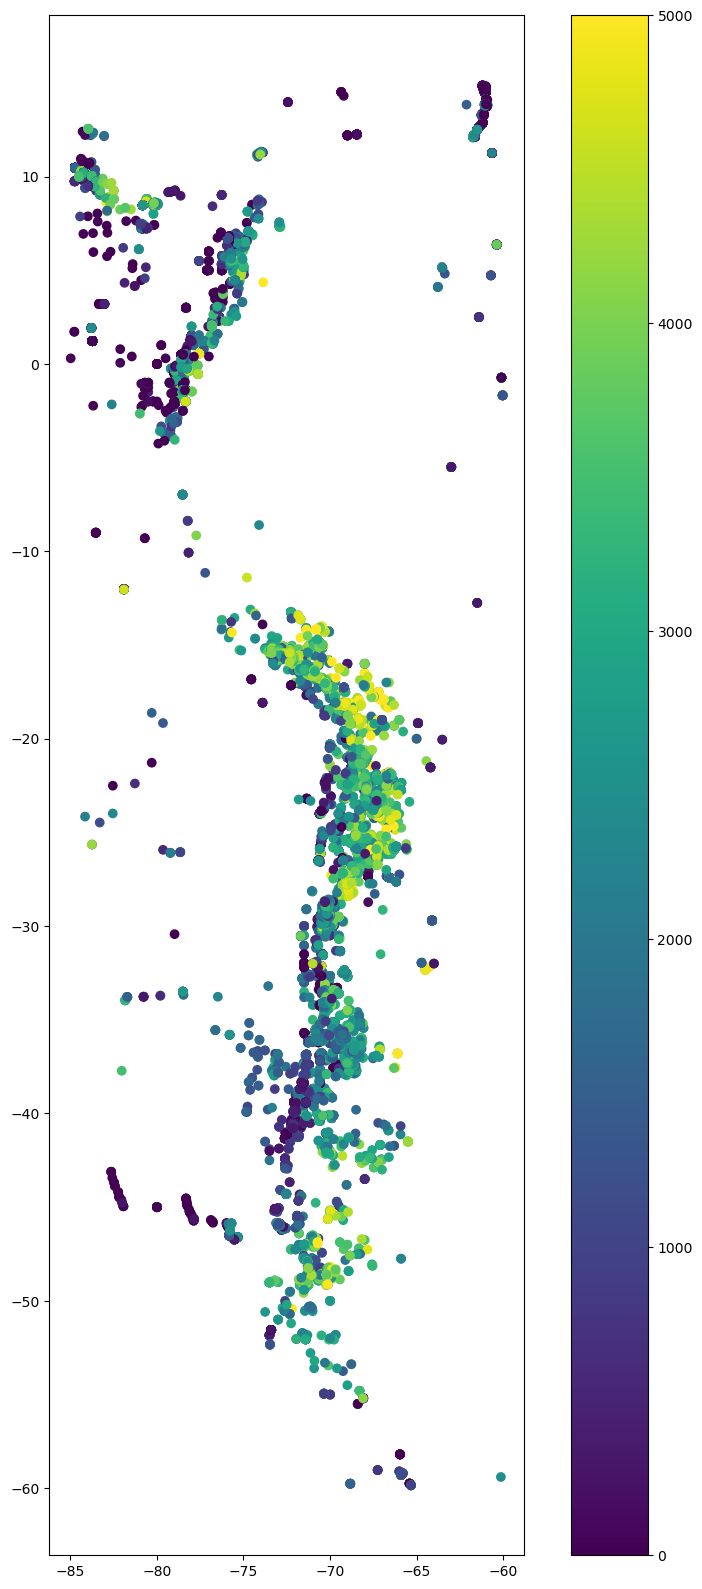

In [7]:
fig,ax = plt.subplots(figsize=(12,20))
elevations_df.plot(column=0, ax=ax, vmin=0, vmax=5000, legend=True)
#plt.colorbar()